In [2]:
import os
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
# Load data file
data_path = os.getcwd() 
all_data = pd.read_csv(data_path + '/df_all.csv')

all_data.head()

,rgi_id,period,PDD,area,icecap,lat,prcp_01,prcp_02,prcp_03,prcp_04,...,temp_09,temp_10,temp_11,temp_12,zmax,zmed,zmin,dmdtda,err_dmdtda,target_id
0,RGI60-08.00001,2000-2010,39.787001,0.03,0.0,67.93,59.556398,42.393607,49.464068,40.707838,...,8.765555,13.037779,10.950000,6.391112,250.0,242.0,235.0,-0.458772,0.449120,0.0
1,RGI60-08.00001,2010-2020,41.833601,0.03,0.0,67.93,57.685775,45.119089,49.848962,37.706105,...,8.942221,13.034446,11.120000,7.227779,250.0,242.0,235.0,-0.356250,0.435293,1.0
2,RGI60-08.00002,2000-2010,44.907200,0.03,0.0,67.87,62.082497,43.677873,49.432192,41.313322,...,9.274814,13.517038,11.384073,6.784445,246.0,239.0,228.0,-0.458772,0.449120,2.0
3,RGI60-08.00002,2010-2020,46.980223,0.03,0.0,67.87,59.345685,45.845166,49.957571,37.644466,...,9.423703,13.538149,11.500740,7.632223,246.0,239.0,228.0,-0.356250,0.435293,3.0
4,RGI60-08.00003,2000-2010,35.337201,0.02,0.0,67.82,60.485810,45.600863,55.059464,46.842254,...,7.059999,11.433335,9.346666,4.700001,749.0,726.0,701.0,-0.458772,0.449120,4.0


## Surface Mass Balance data exploration

In [5]:
all_data.columns

Index(['rgi_id', 'period', 'PDD', 'area', 'icecap', 'lat', 'prcp_01',
       'prcp_02', 'prcp_03', 'prcp_04', 'prcp_05', 'prcp_06', 'prcp_07',
       'prcp_08', 'prcp_09', 'prcp_10', 'prcp_11', 'prcp_12', 'rain', 'slope',
       'snow', 'temp_01', 'temp_02', 'temp_03', 'temp_04', 'temp_05',
       'temp_06', 'temp_07', 'temp_08', 'temp_09', 'temp_10', 'temp_11',
       'temp_12', 'zmax', 'zmed', 'zmin', 'dmdtda', 'err_dmdtda', 'target_id'],
      dtype='object')

<Axes: >

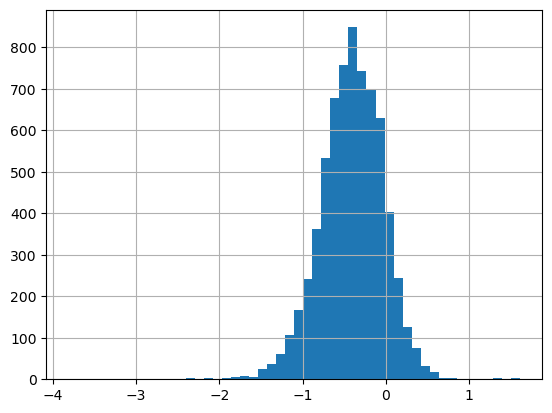

In [3]:
all_data['dmdtda'].hist(bins=50)  # overall negative mass balance for glaciers in study area

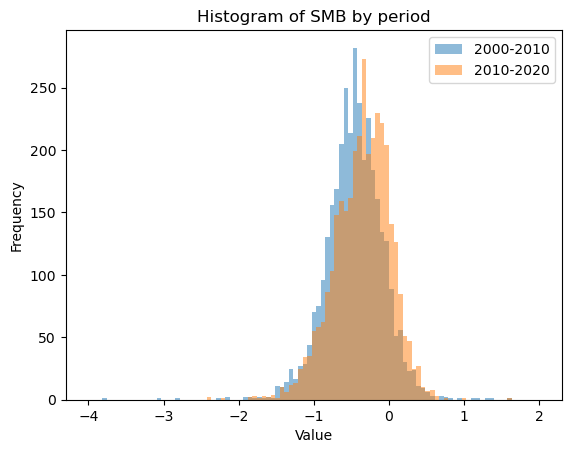

In [24]:
# is there a significant difference in surface mass balance by period?

period1 = all_data[all_data['period'] == '2000-2010']
period2 = all_data[all_data['period'] == '2010-2020']

bins = np.linspace(-4, 2, 100)

plt.hist(period1['dmdtda'], bins, alpha=0.5, label='2000-2010')
plt.hist(period2['dmdtda'], bins, alpha=0.5, label='2010-2020')
plt.title("Histogram of SMB by period")
plt.ylabel("Frequency")
plt.xlabel("Value")
plt.legend(loc='upper right')
plt.savefig(data_path + "/smbHist.png")
plt.show()

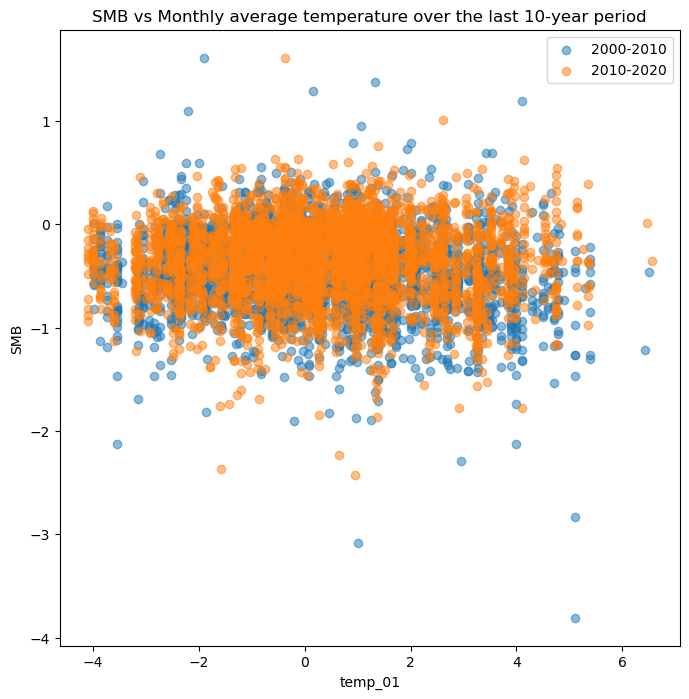

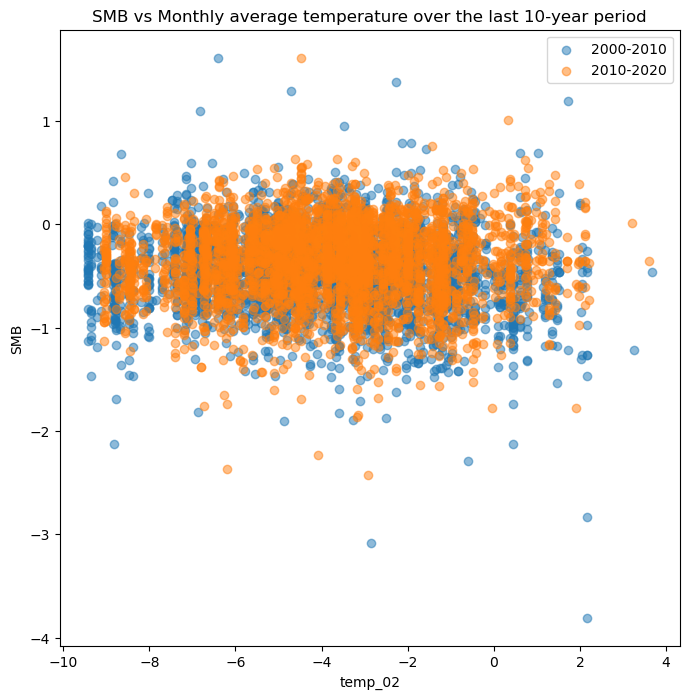

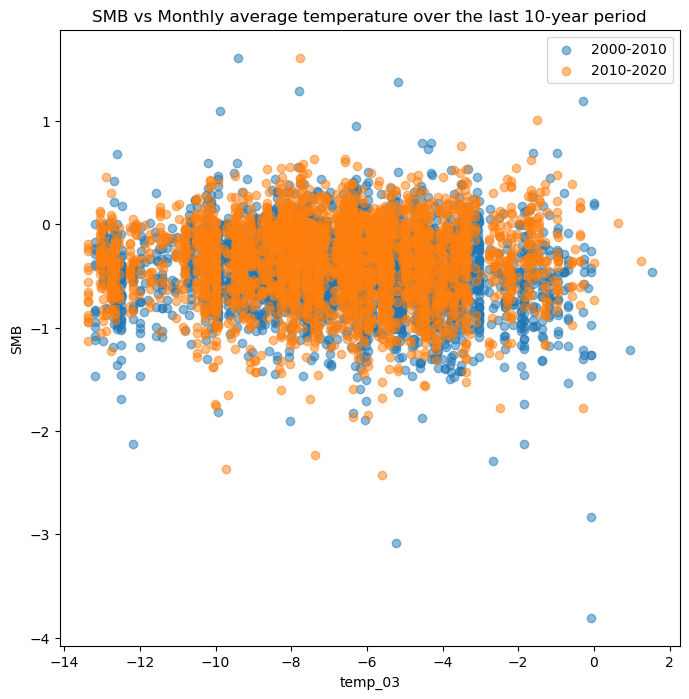

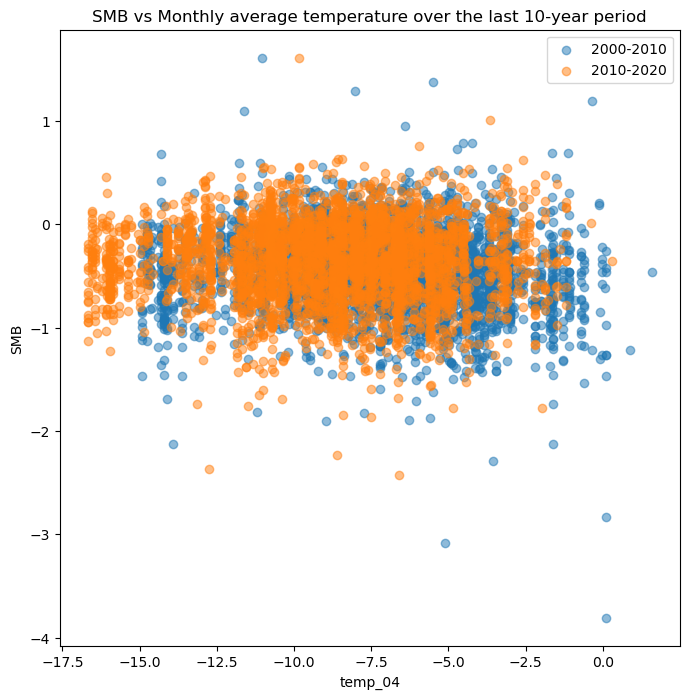

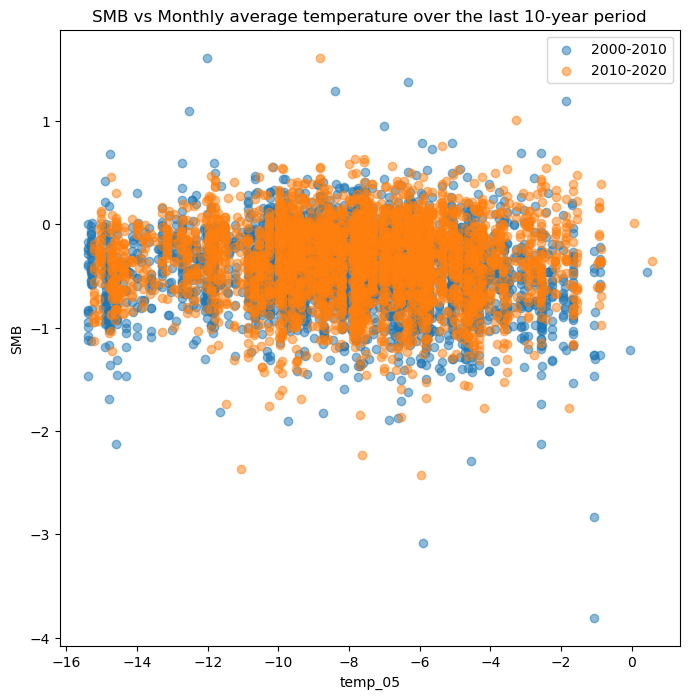

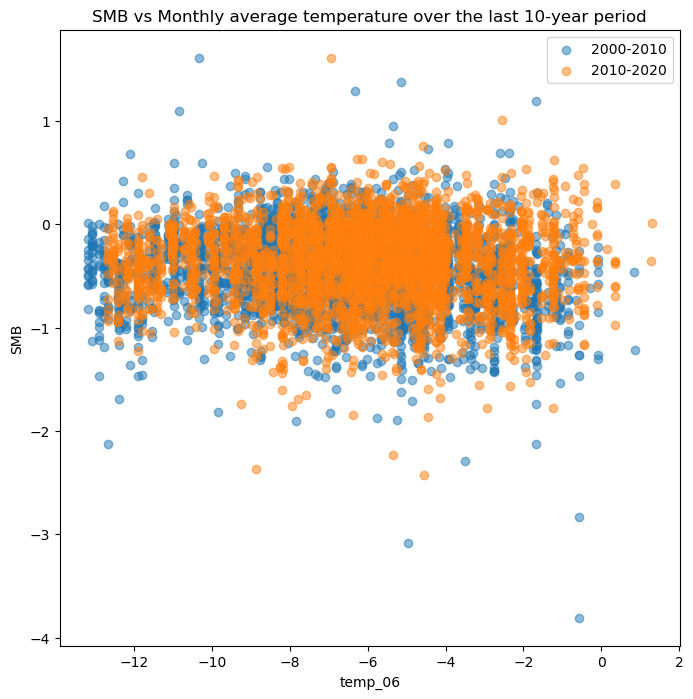

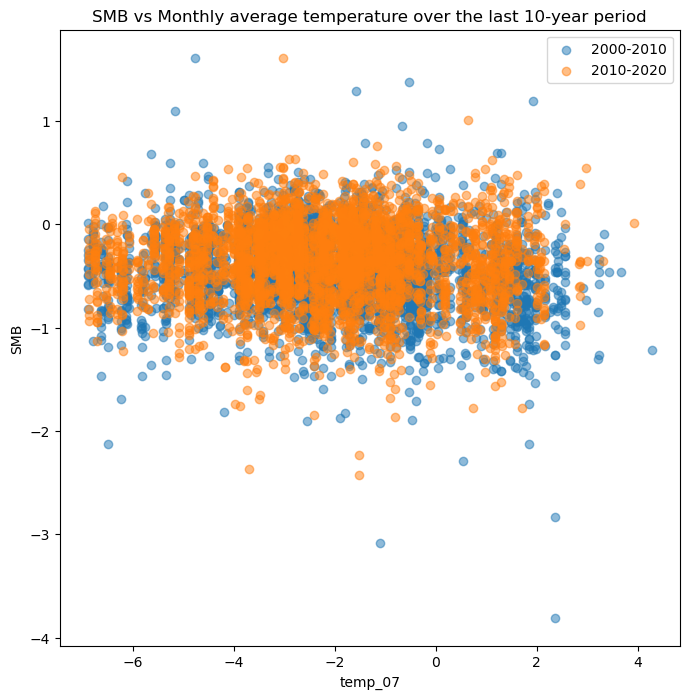

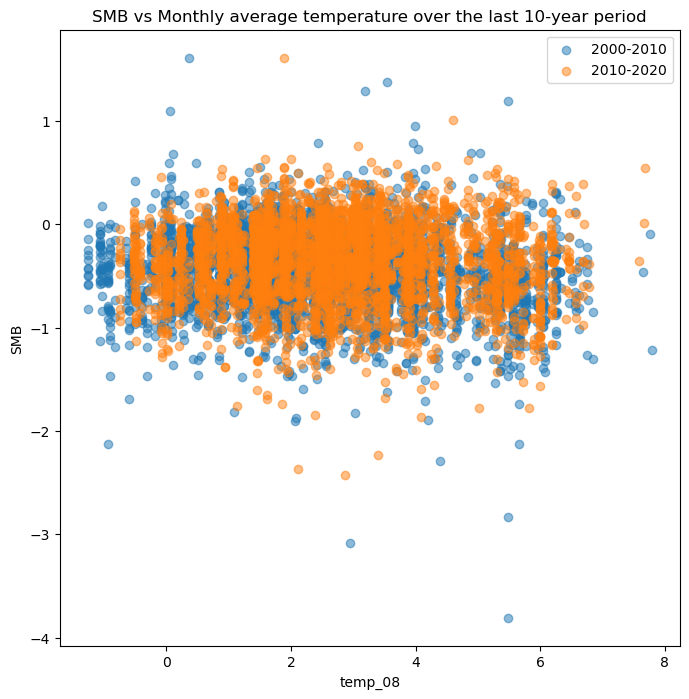

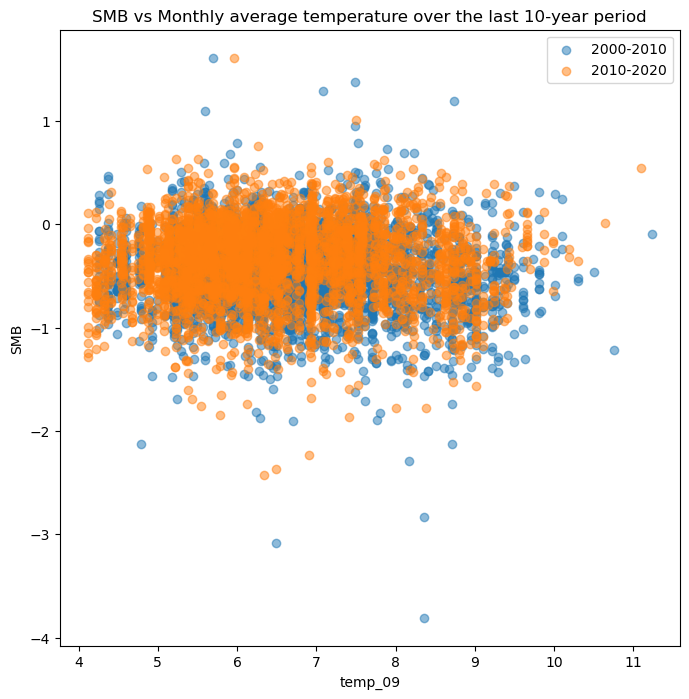

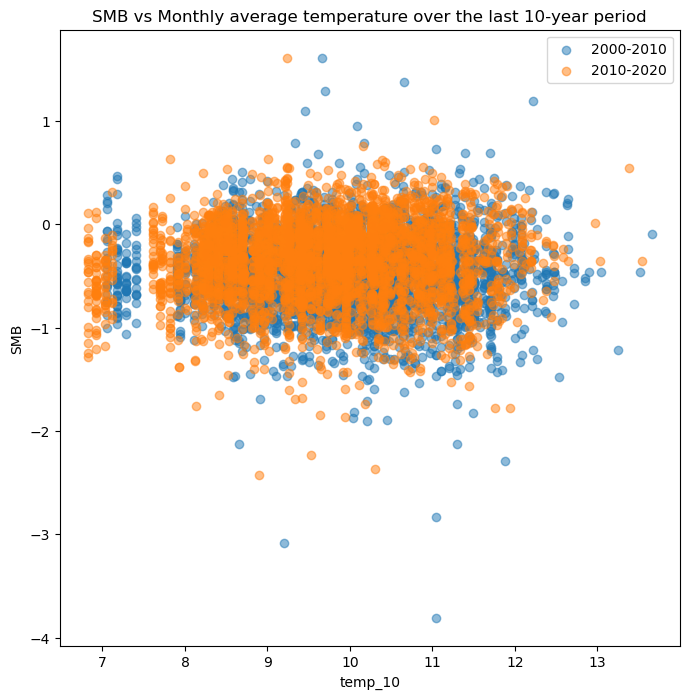

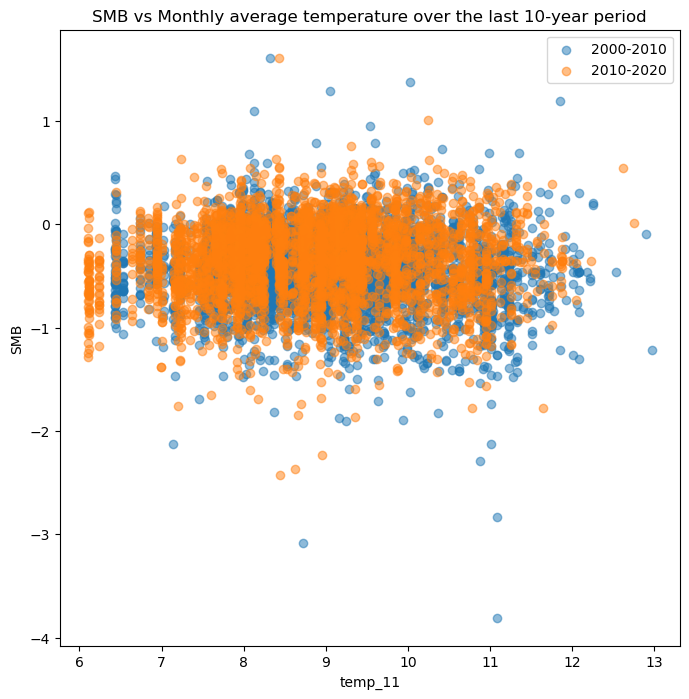

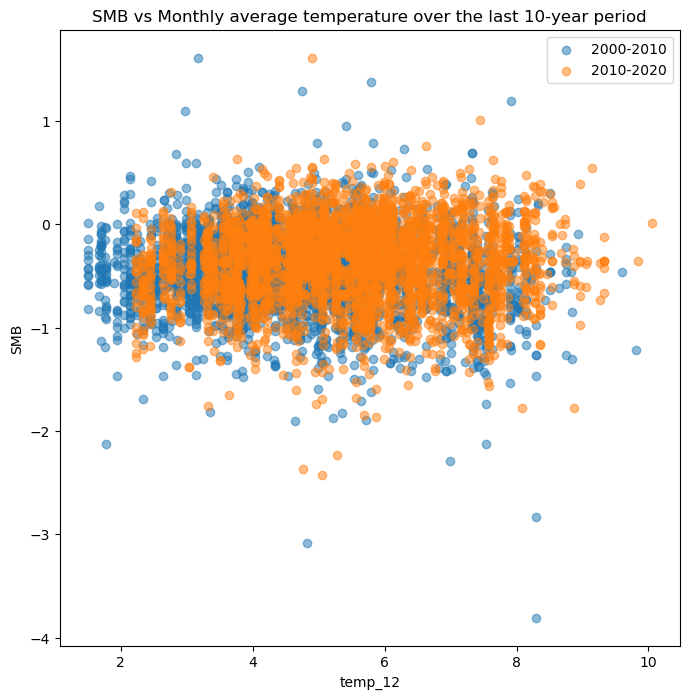

In [29]:
# is there a relationship between mass balance and the temperature variables?

cols = []

for t in range(12):
    yr = t + 1
    if yr < 10:
        yr = "0" + str(yr)
    else:
        yr = str(yr)

    cols.append("temp_" + yr)

# save a random scatterplot
to_save = random.randint(0, 11)
to_save = cols[to_save]

for col in cols:
    plt.figure(figsize=(8,8))
    plt.scatter(period1.loc[:, col], period1["dmdtda"], alpha=0.5, label='2000-2010')
    plt.scatter(period2.loc[:, col], period2["dmdtda"], alpha=0.5, label='2010-2020')
    plt.title("SMB vs Monthly average temperature over the last 10-year period")
    plt.xlabel(col)
    plt.ylabel("SMB")
    plt.legend(loc='upper right')
    if col == to_save:
        plt.savefig(data_path + "/" + col + ".png")
    plt.show()

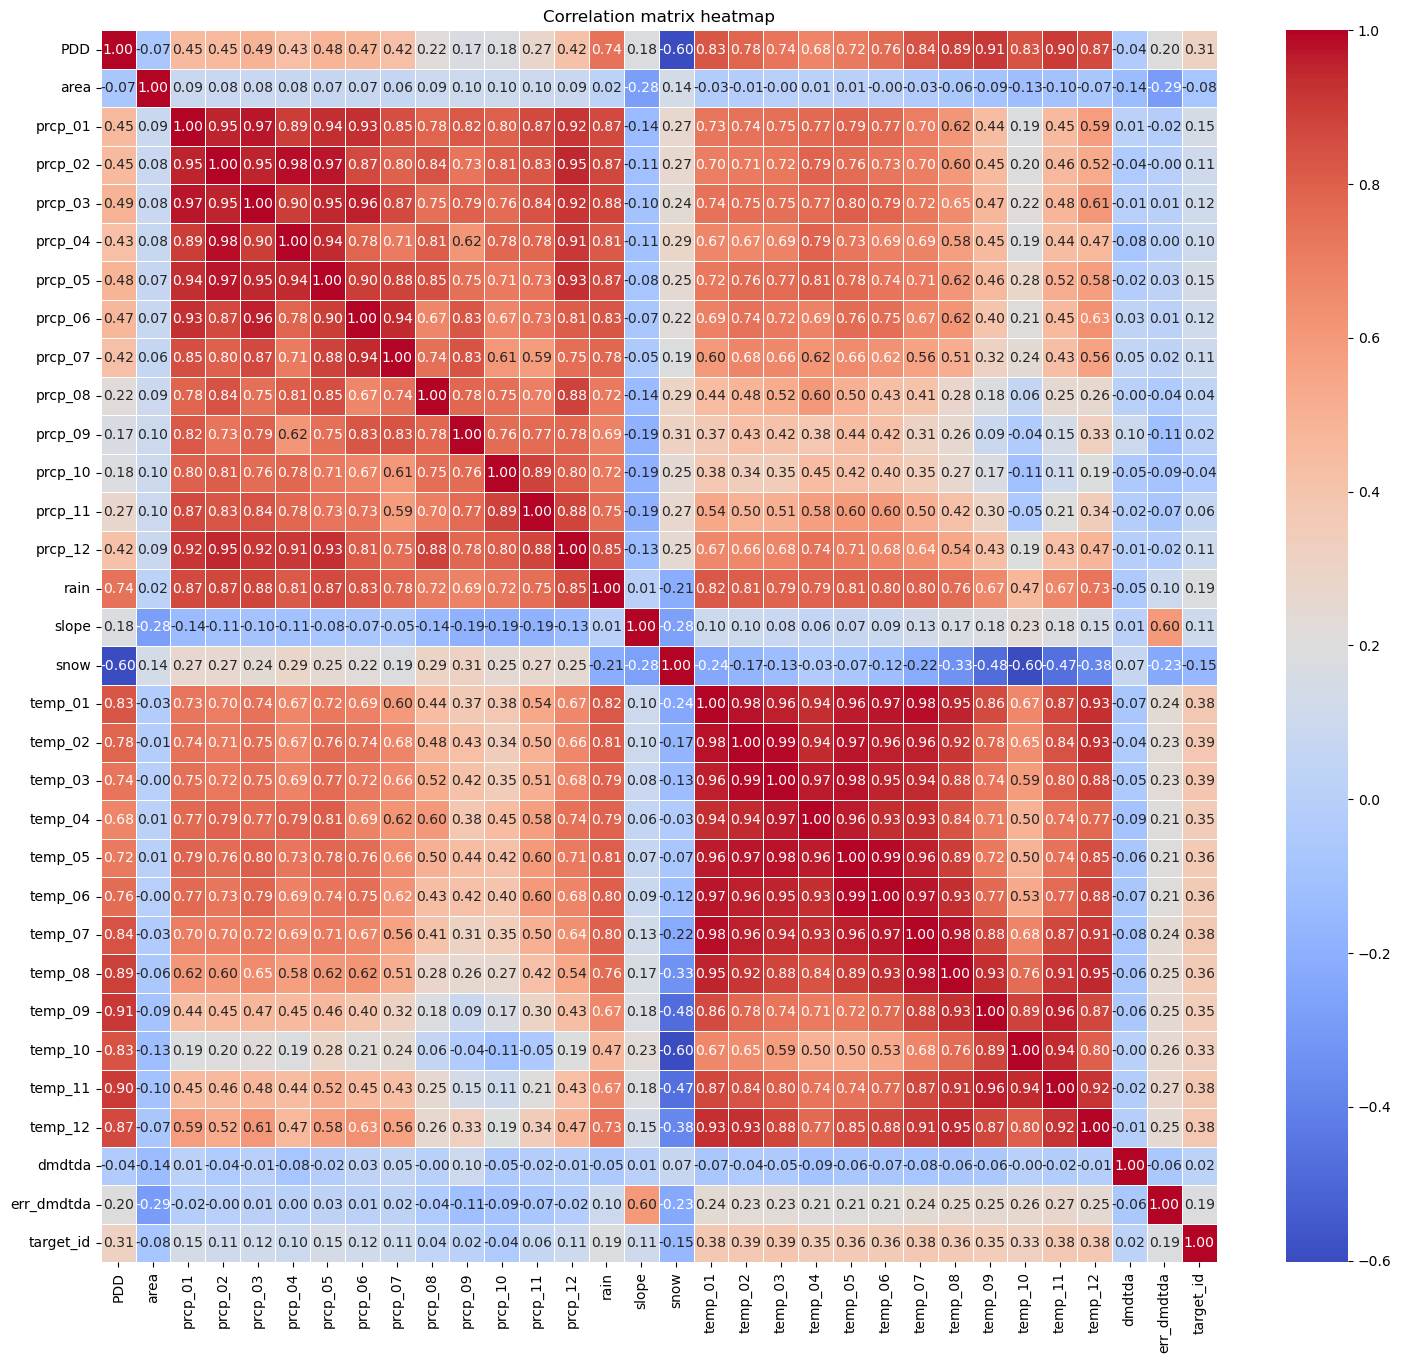

In [30]:
# Drop some columns (eg. non-numeric values, geometric values) to make a correlation heatmap
data_num = all_data.drop(['rgi_id', 'period', 'icecap', 'lat', 'zmax', 'zmin', 'zmed'], axis=1)

plt.figure(figsize=(18,16))
sns.heatmap(data_num.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation matrix heatmap")
plt.savefig(data_path + "/corrMap.png")
plt.show()

## Preparing datasets

In [31]:
# Grab indices of training & test sets using sklearn function on full dataset
glacier_ids = np.unique(all_data.index.get_level_values(0).values)

# Separate dataset
train, tes = train_test_split(glacier_ids, train_size=0.7, test_size=0.3)
train = all_data.loc[train]
test = all_data.loc[tes]

train.shape, test.shape

((4783, 39), (2051, 39))

In [34]:
# For each dataset, create a feature matrix and a target vector for the models

def separate_data(dataset, name):
    features_to_drop = ['dmdtda', 'err_dmdtda', 'target_id']
    data_X = dataset.drop(features_to_drop, axis=1)
    data_y = dataset['dmdtda']

    data_X.to_csv(data_path + f'/{name}_X.csv')
    data_y.to_csv(data_path + f'/{name}_y.csv')

    print(f'Separated & saved {name} data.')

data_to_sep = [train, test]
names = ['train', 'test']

for i in range(2):
    separate_data(data_to_sep[i], names[i])

Separated & saved train data.
Separated & saved test data.
